In [1]:
import torch, torchvision
from torchvision import datasets, transforms
from torch import nn, optim
from torch.nn import functional as F

import numpy as np
import shap

In [2]:
batch_size = 128
num_epochs = 2
device = torch.device('cpu')

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 10, kernel_size=5),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(10, 20, kernel_size=5),
            nn.Dropout(),
            nn.MaxPool2d(2),
            nn.ReLU(),
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(320, 50),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(50, 10),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(-1, 320)
        x = self.fc_layers(x)
        return x

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output.log(), target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output.log(), target).item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('mnist_data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor()
                   ])),
    batch_size=batch_size, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('mnist_data', train=False, transform=transforms.Compose([
                       transforms.ToTensor()
                   ])),
    batch_size=batch_size, shuffle=True)

model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

for epoch in range(1, num_epochs + 1):
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)



The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.309994
Train Epoch: 1 [12800/60000 (21%)]	Loss: 2.266785
Train Epoch: 1 [25600/60000 (43%)]	Loss: 1.915021
Train Epoch: 1 [38400/60000 (64%)]	Loss: 1.128860
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.570706

Test set: Average loss: 0.0050, Accuracy: 8817/10000 (88%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.766599
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.778961
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.684427
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.490559
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.577740

Test set: Average loss: 0.0026, Accuracy: 9345/10000 (93%)



In [3]:
# since shuffle=True, this is a random sample of test data
batch = next(iter(test_loader))
images, _ = batch

In [4]:
background = images[:100]
test_images = images[100:]

In [5]:
background.shape

torch.Size([100, 1, 28, 28])

In [6]:
e = shap.DeepExplainer(model, background)

In [7]:
background.shape

torch.Size([100, 1, 28, 28])

In [8]:
test_images.shape

torch.Size([28, 1, 28, 28])

In [9]:
shap_values = e.shap_values(test_images)

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


In [10]:
shap_v = np.array(shap_values)

In [11]:
shap_v.shape

(10, 28, 1, 28, 28)

In [12]:
shap_v_sum = shap_v.sum(axis=-1).sum(axis=-1).sum(axis=-1)

In [13]:
shap_v_sum.shape

(10, 28)

In [14]:
import matplotlib.pyplot as plt

In [15]:
shap_v_select = shap_v_sum.argmax(axis=0)

In [16]:
shap_v_select

array([1, 7, 3, 7, 0, 9, 0, 2, 3, 7, 6, 4, 0, 9, 5, 1, 3, 7, 8, 0, 8, 5,
       2, 4, 8, 6, 6, 6], dtype=int64)

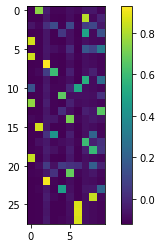

In [17]:
plt.imshow(shap_v_sum.T)
plt.colorbar()

In [18]:
shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]
test_numpy = np.swapaxes(np.swapaxes(test_images.numpy(), 1, -1), 1, 2)

In [25]:
len(shap_numpy)

10

In [26]:
len(shap_numpy[0])

28

In [27]:
len(shap_numpy[0][0])

28

In [28]:
len(shap_numpy[0][0][0])

28

In [29]:
len(shap_numpy[0][0][0][0])

1

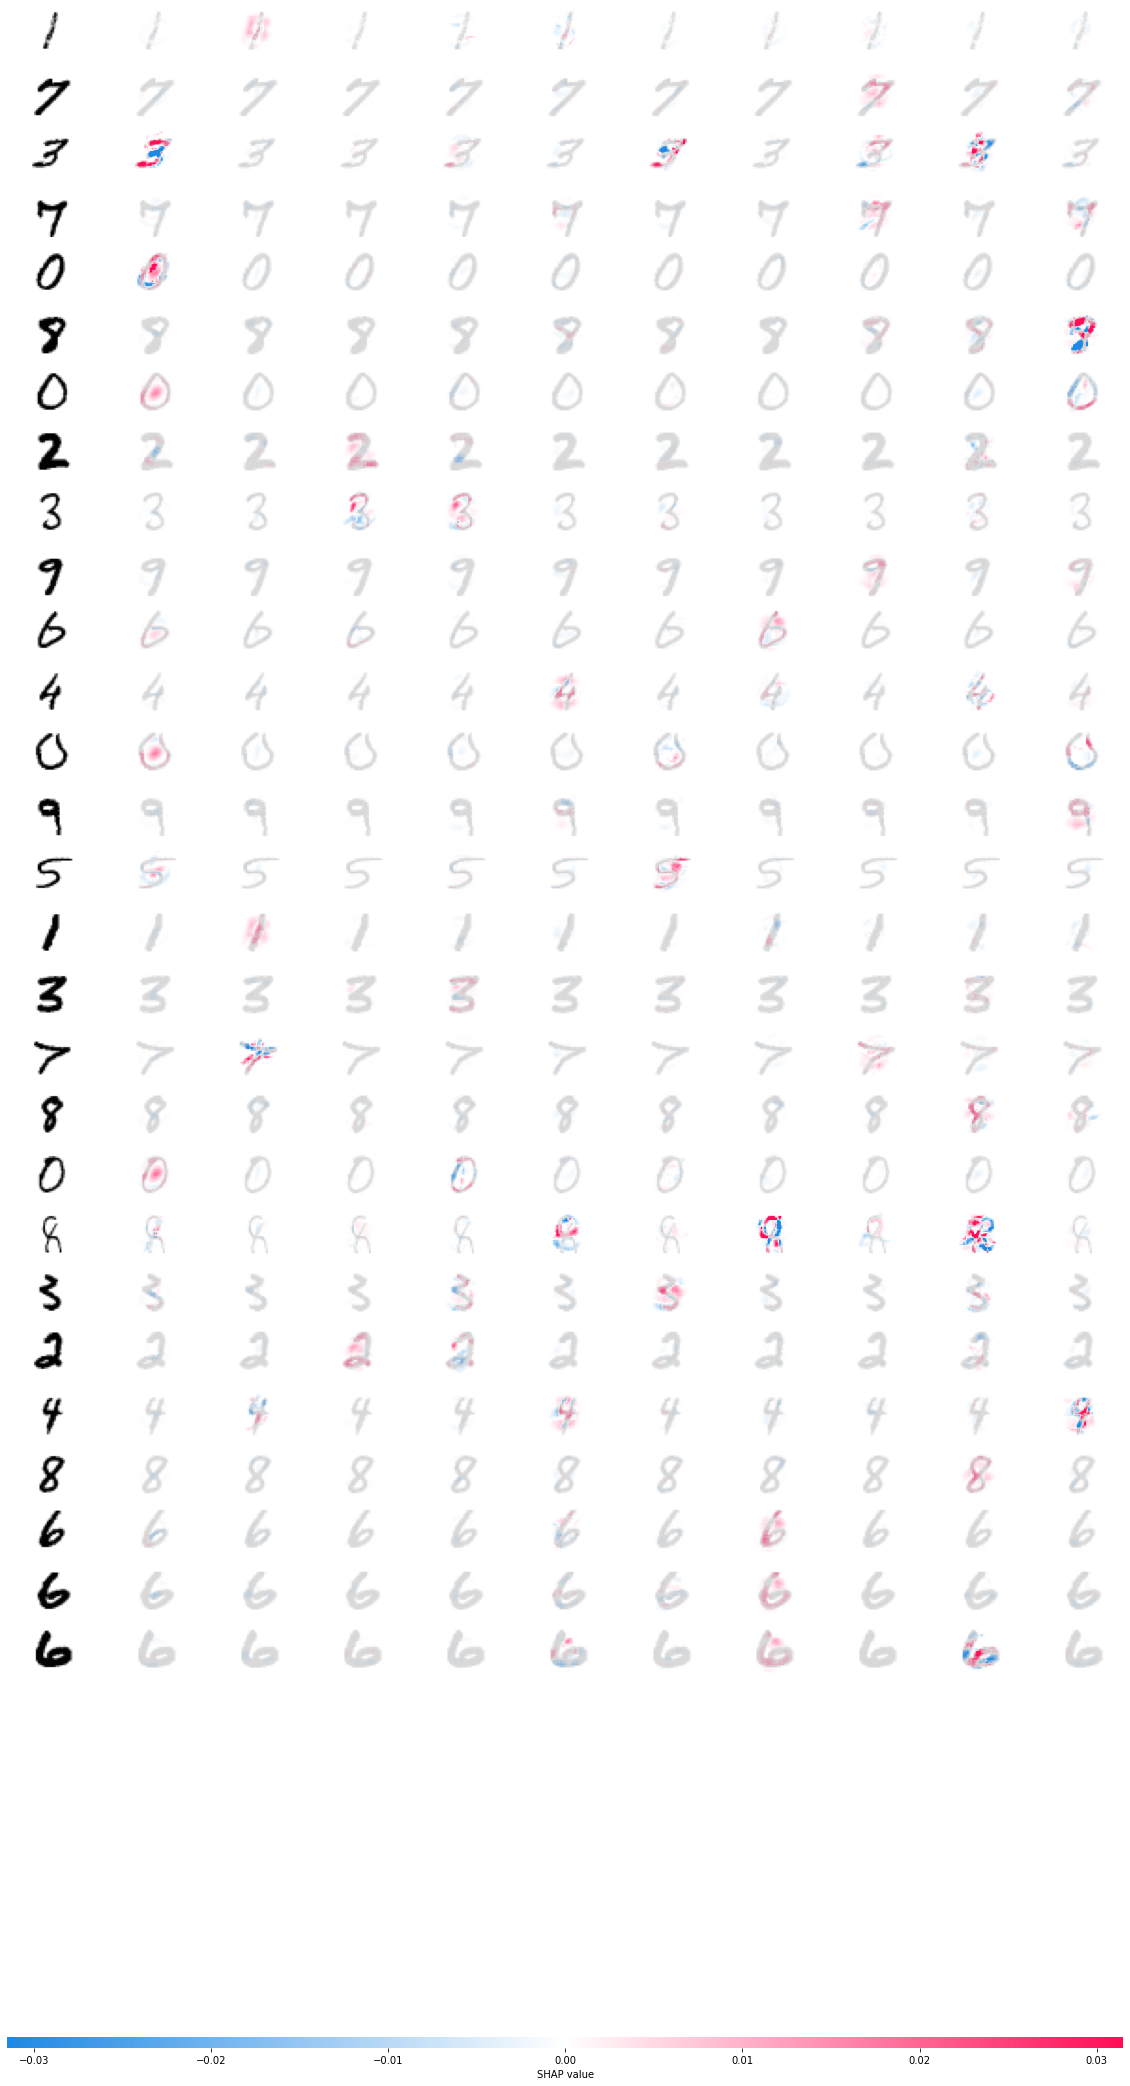

In [19]:
# plot the feature attributions
shap.image_plot(shap_numpy, -test_numpy)

In [20]:
len(shap_values)

10

In [21]:
len(shap_values[0])

28

In [22]:
len(shap_values[0][0])

1

In [23]:
len(shap_values[0][0][0])

28

In [24]:
shap_values[0][0][0][0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [43]:
len(shap_values[0][0][0][0])

28

In [19]:
images.shape

torch.Size([128, 1, 28, 28])

In [51]:
shap.plots.bar(e)

AssertionError: You must pass an Explanation object, Cohorts object, or dictionary to bar plot!